Initial shape: (466285, 75)

LOGISTIC REGRESSION
AUC: 0.9166

RANDOM FOREST
AUC: 0.9567


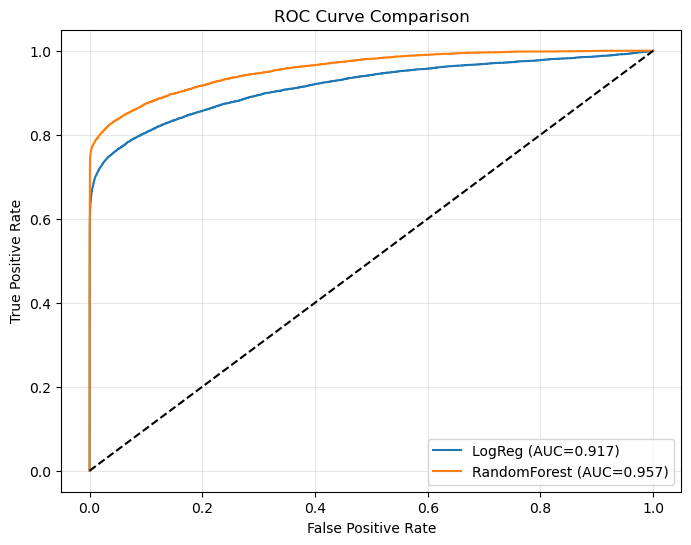


BEST THRESHOLD (RandomForest)
Threshold: 0.52
F1-score: 0.856

FINAL CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     82191
           1       0.97      0.76      0.86     11066

    accuracy                           0.97     93257
   macro avg       0.97      0.88      0.92     93257
weighted avg       0.97      0.97      0.97     93257



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report
)


df = pd.read_csv("loan_data_2007_2014.csv", low_memory=False)
print("Initial shape:", df.shape)


BAD_STATUS = [
    "Charged Off",
    "Default",
    "Does not meet the credit policy. Status:Charged Off",
    "Late (31-120 days)",
    "Late (16-30 days)",
    "In Grace Period"
]

df["target"] = np.where(df["loan_status"].isin(BAD_STATUS), 1, 0)


LEAKAGE_COLS = [
    "recoveries", "collection_recovery_fee", "total_rec_prncp",
    "total_rec_int", "total_rec_late_fee",
    "last_pymnt_d", "last_pymnt_amnt",
    "next_pymnt_d", "last_credit_pull_d"
]

ID_COLS = [
    "id", "member_id", "url", "desc", "title",
    "zip_code", "addr_state", "earliest_cr_line"
]

df.drop(columns=[c for c in LEAKAGE_COLS + ID_COLS if c in df.columns],
        inplace=True, errors="ignore")


if "term" in df.columns:
    df["term"] = (
        df["term"]
        .astype(str)
        .str.extract(r"(\d+)")
        .astype(float)
    )

# emp_length
if "emp_length" in df.columns:
    df["emp_length"] = (
        df["emp_length"]
        .astype(str)
        .str.replace("+", "", regex=False)
        .str.replace("< 1", "0", regex=False)
        .str.extract(r"(\d+)")
        .fillna(0)
        .astype(float)
    )

# int_rate & revol_util (FINAL FIX)
for col in ["int_rate", "revol_util"]:
    if col in df.columns:
        if df[col].dtype == "object":
            df[col] = (
                df[col]
                .str.replace("%", "", regex=False)
                .astype(float)
            )
        else:
            df[col] = df[col].astype(float)


missing_ratio = df.isnull().mean()
df.drop(columns=missing_ratio[missing_ratio > 0.5].index, inplace=True)


ORDINAL_COLS = ["grade", "sub_grade"]
LOW_CARDINALITY = ["home_ownership", "verification_status", "purpose"]
NUMERIC_COLS = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

NUMERIC_COLS = [
    c for c in NUMERIC_COLS
    if c not in ["target"]
]


from sklearn.impute import SimpleImputer

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

ordinal_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(
        handle_unknown="ignore",
        drop="first",
        sparse_output=False
    ))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, NUMERIC_COLS),
        ("ord", ordinal_pipeline, ORDINAL_COLS),
        ("cat", categorical_pipeline, LOW_CARDINALITY),
    ],
    remainder="drop"
)


X = df.drop(columns=["target", "loan_status"], errors="ignore")
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


logreg_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

logreg_pipeline.fit(X_train, y_train)

y_prob_lr = logreg_pipeline.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, y_prob_lr)

print("\nLOGISTIC REGRESSION")
print("AUC:", round(auc_lr, 4))


rf_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=100,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)

y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_prob_rf)

print("\nRANDOM FOREST")
print("AUC:", round(auc_rf, 4))


fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={auc_rf:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


def find_best_threshold(y_true, y_prob):
    best_t, best_f1 = 0, 0
    for t in np.linspace(0.1, 0.9, 81):
        preds = (y_prob >= t).astype(int)
        report = classification_report(
            y_true, preds, output_dict=True
        )
        f1 = report["1"]["f1-score"]
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

best_t, best_f1 = find_best_threshold(y_test, y_prob_rf)

print("\nBEST THRESHOLD (RandomForest)")
print("Threshold:", round(best_t, 3))
print("F1-score:", round(best_f1, 3))


final_preds = (y_prob_rf >= best_t).astype(int)

print("\nFINAL CLASSIFICATION REPORT")
print(classification_report(y_test, final_preds))
